# 6: Earley parsing and PCFGs

## 1. Earley parsing in NLTK

We will start by creating a CFG.

In [1]:
from nltk.grammar import CFG

grammar = CFG.fromstring('''S -> NP VP
NP -> DT NN
VP -> VBD
VP -> VBD NP
DT -> "the"
NN -> "dog"
NN -> "saw"
NN -> "cat"
VBD -> "saw"
''')

We can then create an Earley parser and parse a sentence.

|.  the  .  cat  .  saw  .  the  .  dog  .|
|[-------]       .       .       .       .| [0:1] 'the'
|.       [-------]       .       .       .| [1:2] 'cat'
|.       .       [-------]       .       .| [2:3] 'saw'
|.       .       .       [-------]       .| [3:4] 'the'
|.       .       .       .       [-------]| [4:5] 'dog'
|>       .       .       .       .       .| [0:0] S  -> * NP VP
|>       .       .       .       .       .| [0:0] NP -> * DT NN
|>       .       .       .       .       .| [0:0] DT -> * 'the'
|[-------]       .       .       .       .| [0:1] DT -> 'the' *
|[------->       .       .       .       .| [0:1] NP -> DT * NN
|.       >       .       .       .       .| [1:1] NN -> * 'cat'
|.       [-------]       .       .       .| [1:2] NN -> 'cat' *
|[---------------]       .       .       .| [0:2] NP -> DT NN *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|.       .       >       .       .       .| [2:2] VP -> * VBD
|.       .       >       .       .    

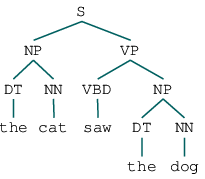

In [2]:
from nltk.parse import EarleyChartParser

# Use the trace option to print the Earley parse table
earley_parser = EarleyChartParser(grammar, trace=1)

earley_parser.parse_one("the cat saw the dog".split(" "))

Here's an annotated version of the trace:

```
|.  the  .  cat  .  saw  .  the  .  dog  .|
|[-------]       .       .       .       .| [0:1] 'the'          # The parser first prints all our word forms
|.       [-------]       .       .       .| [1:2] 'cat'
|.       .       [-------]       .       .| [2:3] 'saw'
|.       .       .       [-------]       .| [3:4] 'the'
|.       .       .       .       [-------]| [4:5] 'dog'
|>       .       .       .       .       .| [0:0] S  -> * NP VP  # This is the START operation
|>       .       .       .       .       .| [0:0] NP -> * DT NN  # We use the predictor and then the scanner
|>       .       .       .       .       .| [0:0] DT -> * 'the'
|[-------]       .       .       .       .| [0:1] DT -> 'the' *  # Indicates that a lexical rule matched
|[------->       .       .       .       .| [0:1] NP -> DT * NN  # The completer advances one of our rules
|.       >       .       .       .       .| [1:1] NN -> * 'cat'
|.       [-------]       .       .       .| [1:2] NN -> 'cat' *  # Matching a lexical rule again
|[---------------]       .       .       .| [0:2] NP -> DT NN *  # And this triggers completion of an NP rule
|[--------------->       .       .       .| [0:2] S  -> NP * VP  # Which in turn advances our S rule
|.       .       >       .       .       .| [2:2] VP -> * VBD    # The predictor copies VP rules for us
|.       .       >       .       .       .| [2:2] VP -> * VBD NP
|.       .       >       .       .       .| [2:2] VBD -> * 'saw' # Matching a lexical rule again
|.       .       [-------]       .       .| [2:3] VBD -> 'saw' *
|.       .       [-------]       .       .| [2:3] VP -> VBD *    # VP rules are advanced
|.       .       [------->       .       .| [2:3] VP -> VBD * NP
|.       .       .       >       .       .| [3:3] NP -> * DT NN  # The predictor copies NP rules
|.       .       .       >       .       .| [3:3] DT -> * 'the'  # Matching a lexical rule again
|[-----------------------]       .       .| [0:3] S  -> NP VP *  # We got an S match here for "the cat saw"
|.       .       .       [-------]       .| [3:4] DT -> 'the' *  # Matching a lexical rule again
|.       .       .       [------->       .| [3:4] NP -> DT * NN  # The predictor copies NP rules
|.       .       .       .       >       .| [4:4] NN -> * 'dog'  # Matching a lexical rule again
|.       .       .       .       [-------]| [4:5] NN -> 'dog' *  
|.       .       .       [---------------]| [3:5] NP -> DT NN *  # Completion of the NP rule
|.       .       [-----------------------]| [2:5] VP -> VBD NP * # Completion of the VP rule
|[=======================================]| [0:5] S  -> NP VP *  # And, finally, completion of our S rule
```

## 2. PCFG parsing 

This is how to create a PCFG and parse:

In [3]:
from nltk import PCFG

pcfg = PCFG.fromstring('''S -> NP VP [1.0]
NP -> DT NN [0.9] | NP PP [0.1]
VP -> VBZ NP [0.6] | VP PP [0.4]
PP -> IN NP [1.0]
NN -> "dog" [0.5] | "bone" [0.2] | "porch" [0.3]
VBZ -> "eats" [1.0]
IN -> "on" [1.0]
DT -> "the" [0.5] | "a" [0.5]
''')

from nltk.parse import InsideChartParser

parser = InsideChartParser(pcfg)

for tree in parser.parse("the dog eats a bone on the porch".split(" ")):
    print(tree)

(S
  (NP (DT the) (NN dog))
  (VP
    (VP (VBZ eats) (NP (DT a) (NN bone)))
    (PP (IN on) (NP (DT the) (NN porch))))) (p=0.0006561)
(S
  (NP (DT the) (NN dog))
  (VP
    (VBZ eats)
    (NP
      (NP (DT a) (NN bone))
      (PP (IN on) (NP (DT the) (NN porch)))))) (p=0.000164025)


For longer sentences and realistic grammars, there might be hundreds or thousands of distinct parse trees. It is not a good idea to generate all of these. Instead we want to use the probabilistic CYK algorithm (or something similar) to generate only the most probable tree. We can do this using `ViterbiParser` which is an implementation of probabilistic CYK. 

In [4]:
from nltk.parse.viterbi import ViterbiParser

parser = ViterbiParser(pcfg)

for tree in parser.parse("the dog eats a bone on the porch".split(" ")):
    print(tree)

(S
  (NP (DT the) (NN dog))
  (VP
    (VP (VBZ eats) (NP (DT a) (NN bone)))
    (PP (IN on) (NP (DT the) (NN porch))))) (p=0.0006561)
